In [2]:
%load_ext autoreload

In [3]:
%autoreload
from mine.models.mine import Mine
import torch.nn as nn
import numpy as np
import torchvision
import torch
import torchvision.transforms as transforms
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pickle

Device: cuda


In [2]:
x_dim=1
y_dim=1
batch_size = 32

In [5]:
statistics_network = nn.Sequential(
    nn.Linear(x_dim + y_dim, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 1)
)

mine = Mine(
    T = statistics_network,
    loss = 'mine', #mine_biased, fdiv
    method = 'concat'
)

joint_samples = np.random.multivariate_normal(np.array([0,0]), np.array([[1, 0], [0, 1]]), 600)
print(joint_samples.shape)
X, Y = joint_samples[:, 0], joint_samples[:, 1]

X = torch.tensor(X).unsqueeze(dim=1)
Y = torch.tensor(Y).unsqueeze(dim=1)
X = X.numpy()
Y = Y.numpy()
mi, loss_log = mine.optimize(X, Y, 200, batch_size)

Final MI: 0.03530861437320709


In [23]:
mine.T

CustomSequential(
  (0): ConcatLayer()
  (1): Linear(in_features=150529, out_features=1, bias=True)
  (2): ReLU()
  (3): Linear(in_features=1, out_features=100, bias=True)
  (4): ReLU()
  (5): Linear(in_features=100, out_features=1, bias=True)
)

In [ ]:
X = torch.tensor(X).unsqueeze(dim=1)
Y = torch.tensor(Y).unsqueeze(dim=1)

In [ ]:
X.unsqueeze(dim=-1).shape, Y.shape, torch.cat((X, Y), dim=1).shape

In [ ]:
Y.shape

In [ ]:
mean = [0,0]
cov = [[1, 0], [0, 100]]
x, y = np.random.multivariate_normal(mean, cov, 5000).T
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()

In [ ]:
joint_samples[:,1].shape

In [ ]:
!pip list

In [4]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(device)

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

batch_size = 1024


# USE 100K TEST DATA
dataset = torchvision.datasets.ImageFolder(
    root='/scratch/network/ls1546/imagenet/ILSVRC/Data/CLS-LOC/test', 
    transform=transform
)

# load part of dataset
indices = torch.arange(20000)
dataset_half = torch.utils.data.Subset(dataset, indices)
dataloader = torch.utils.data.DataLoader(dataset_half, batch_size=batch_size, shuffle=True, num_workers=2)

# dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

cuda:1


In [5]:
# device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
weights = torchvision.models.ResNet18_Weights.DEFAULT
model = torchvision.models.resnet18(weights=weights).to(device)
model;

In [6]:
# add hooks, run model with inputs to get activations

# a dict to store the activations
activation = {}
def get_activation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach().cpu().numpy()
        # activation[name] = output.numpy()
    return hook

hook_layer1 = model.layer1[0].conv1.register_forward_hook(get_activation('conv1'))
# hook_relu = model.layer1[0].relu.register_forward_hook(get_activation('relu'))
hook_layer4 = model.layer4[1].conv2.register_forward_hook(get_activation('conv2'))

In [5]:
inputs, _ = next(iter(dataloader))

In [6]:
!pip list |grep torch

mine                      0.0.1       /scratch/network/ls1546/mine-pytorch
pytorch-lightning         2.1.0
torch                     2.1.0
torchmetrics              1.2.0
torchvision               0.15.2


In [7]:
inputs_list = []
conv_list = []
# relu_list = []
conv2_list = []

for inputs, _ in tqdm(dataloader):
    
    inputs = inputs.to(device)

    with torch.no_grad():
        output = model(inputs)
        
        # collect the activations
        conv_list.append(activation['conv1'])
        # relu_list.append(activation['relu'])
        conv2_list.append(activation['conv2'])

        inputs = inputs.detach().cpu().numpy()
        # inputs = inputs.numpy()
        inputs_list.append(inputs)

    del inputs
    
# detach the hooks
hook_layer1.remove()
# hook_relu.remove()
hook_layer4.remove()

100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:34<00:00,  4.74s/it]


In [ ]:
len(inputs_list), inputs_list[0].shape, len(conv_list), conv_list[0].shape

In [8]:
act_length = (len(conv_list) - 1)*batch_size + len(conv_list[len(conv_list)-1])
act_length

20000

In [9]:
images_flat = np.zeros((act_length, 224*224*3))
responses = np.zeros((act_length, 1))
x_dim=224*224*3
y_dim=1

# location of activation response on image (here center x and y pos)
c1 = 56//2

# which filter (here first (0))
filter = 0

for batch in range(len(conv_list)):
    for image in range(len(conv_list[batch])):
        responses[batch*len(conv_list[0])+image, 0] = conv_list[batch][image, filter, c1, c1]
        images_flat[batch*len(conv_list[0])+image, :] = inputs_list[batch][image].flatten()

In [10]:
del conv_list
del inputs_list

In [13]:
image_network = nn.Sequential(
    nn.Linear(x_dim + y_dim, 1),
    nn.ReLU(),
    nn.Linear(1, 100),
    nn.ReLU(),
    nn.Linear(100, 1)
)

# image_network = torch.compile(image_network)

mine = Mine(
    T = image_network,
    loss = 'mine', #mine_biased, fdiv
    method = 'concat'
)

mi, loss_log = mine.optimize(images_flat, responses2, 50, batch_size)

  0%|          | 0/50 [00:00<?, ?it/s]

Final MI: -1.7434358596801758e-06


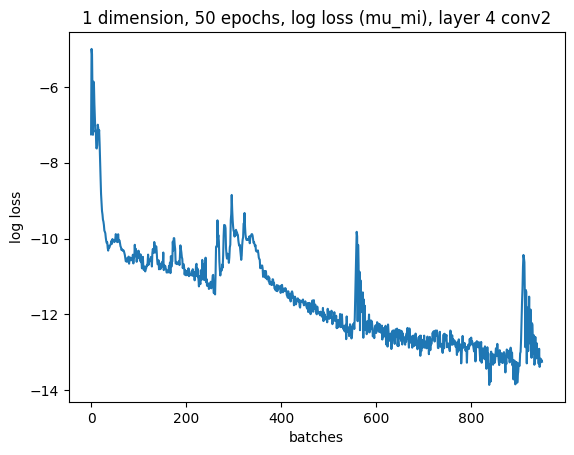

In [14]:
plt.figure()
plt.plot(np.log(torch.stack(loss_log).detach().numpy()))
plt.title("1 dimension, 50 epochs, log loss (mu_mi), layer 4 conv2")
plt.ylabel("log loss")
plt.xlabel("batches")
plt.show()

In [15]:
# save T, mi, loss log, flattened inputs
torch.save(mine.T, 'mineTl4.pth')
np.save('mil4.npy', mi)
np.save('loss_logl4.npy', torch.stack(loss_log).detach().numpy())
# np.save('images_flat.npy', images_flat)
np.save('responses2.npy', responses2)

In [18]:
mine.T

CustomSequential(
  (0): ConcatLayer()
  (1): Linear(in_features=150529, out_features=1, bias=True)
  (2): ReLU()
  (3): Linear(in_features=1, out_features=100, bias=True)
  (4): ReLU()
  (5): Linear(in_features=100, out_features=1, bias=True)
)

In [ ]:
loss_log[825:1000]

In [13]:
images_flat[-1]

array([1.03305078, 1.1871736 , 1.15292406, ..., 0.25220051, 0.44392177,
       0.60078448])

In [16]:
Tweights = mine.T[1].weight[0].detach().numpy()[:-1]
images_weighted = images_flat*Tweights

In [17]:
images_weighted.shape

(20000, 150528)

In [20]:
def scale_rgb(x):
    return ((x - x.min()) / (x.max() - x.min()))

In [18]:
images_weighted = np.reshape(images_weighted, (act_length, 3, 224, 224))

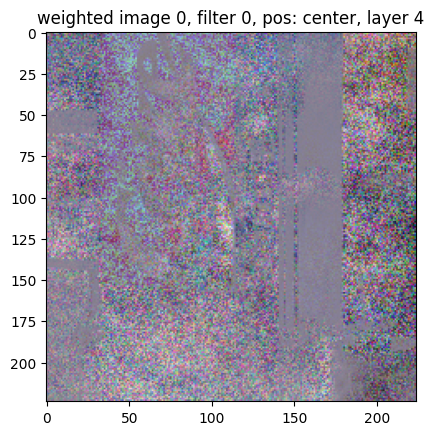

In [21]:
plt.figure()

temp = images_weighted[0, :, :, :].copy()
for k in range(3):
    temp[k, :, :] = scale_rgb(temp[k, :, :])
plt.imshow(np.transpose(temp, (1, 2, 0)))
plt.title("weighted image 0, filter 0, pos: center, layer 4")
plt.show()

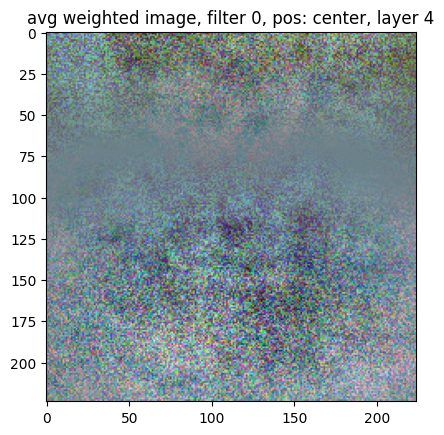

In [22]:
plt.figure()

temp = np.mean(images_weighted, axis=0)
for k in range(3):
    temp[k, :, :] = scale_rgb(temp[k, :, :])
plt.imshow(np.transpose(temp, (1, 2, 0)))
plt.title("avg weighted image, filter 0, pos: center, layer 4")
plt.show()

In [30]:
len(conv2_list), conv2_list[0].shape

(20, (1024, 512, 7, 7))

In [11]:
responses2 = np.zeros((act_length, 1))
x_dim=224*224*3
y_dim=1

# location of activation response on image (here center x and y pos)
c4 = 7//2

# which filter (here first (0))
filter = 0

for batch in range(len(conv2_list)):
    for image in range(len(conv2_list[batch])):
        responses2[batch*len(conv2_list[0])+image, 0] = conv2_list[batch][image, filter, c4, c4]

In [12]:
del conv2_list

In [23]:
mi_d1l1 = np.load('mi.npy')

In [25]:
mi_d1l1, mi

(array(-5.0246716e-05, dtype=float32), tensor(-1.7434e-06))

In [26]:
mi_d1l4 = np.load('mil4.npy')

In [27]:
mi_d1l1, mi, mi_d1l4

(array(-5.0246716e-05, dtype=float32),
 tensor(-1.7434e-06),
 array(-1.7434359e-06, dtype=float32))